# Review VWC

The following notebook is a series of figures and tables to review volumetric water content (VWC) as estimated by Hesham using "representative" bulk density values with VWC values estimated by Bryan Carlson using bulk density values taken in 1999. This reports differs from p10_* report. This report loads the measured/calculated values only.

The term "legacy" values refer to those estimated by Heshram. The term "revised" refer to the values estimated by Carlson.

In [2]:
# Setup
import pandas as pd
import pathlib
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.p00_calculate_vwc_from_revised_bulkdensity import *

inputDir = pathlib.Path.cwd() / "data" / "input"
workingDir = pathlib.Path.cwd() / "data" / "working"
outputDir = pathlib.Path.cwd() / "data" / "output"




In [3]:
# Get output file to review
filePath = sorted(outputDir.glob("VolumetricWaterContentFromRevisedBd_P2_*.csv"))[-1]

In [4]:
# Load data
revisedVwc = pd.read_csv(filePath)

In [5]:
# Load legacy VWC calculated by Hesham using "representative" bulk density values
vwcAggregate = getVwcSpringFallCalcAggregate(
            inputDir / "VwcSpringFallCalc",
            [0, 13, 14, 15, 16, 17],
            ["ID2", "VWC_1", "VWC_2", "VWC_3", "VWC_4", "VWC_5"])
legacyVwc = tidyVwcSpringFallCalcAggregate(
            vwcAggregate, 
            "VolumetricWaterContent")

In [6]:
# Compare VWC values, old/legacy (estimated by Heshram) with new/revised (estimated by Bryan)
vwcCompare = pd.merge(
    legacyVwc, 
    revisedVwc[["ID2", "Year", "Season", "BottomDepth", "VolumetricWaterContent"]], 
    on=["Year", "Season", "ID2", "BottomDepth"],
    suffixes=("_legacy", "_revised"))

## Scatter plot of Legacy vs Revised VWC values for two seasons

In [7]:
sns.set_style("whitegrid")
sns.lmplot(
    x="VolumetricWaterContent_legacy", 
    y="VolumetricWaterContent_revised", 
    hue="Season",
    data=vwcCompare)

In [8]:
vwcCompareMap = pd.merge(
    legacyVwc, 
    revisedVwc[["ID2", "Year", "Season", "Latitude", "Longitude", "BottomDepth", "VolumetricWaterContent"]], 
    how="right",
    on=["Year", "Season", "ID2", "BottomDepth"],
    suffixes=("_legacy", "_revised"))

# Differences between Legacy and Revised VWC

vwcDiff = legacy - revised

In [9]:
import geopandas
gdf = geopandas.GeoDataFrame(
    vwcCompareMap,
    geometry=geopandas.points_from_xy(vwcCompareMap.Longitude, vwcCompareMap.Latitude))
gdf = gdf.assign(
    vwcDiff = gdf["VolumetricWaterContent_legacy"] - gdf["VolumetricWaterContent_revised"])
gdf["coords"] = gdf["geometry"].apply(lambda x: x.representative_point().coords[:])
gdf["coords"] = [coords[0] for coords in gdf["coords"]]
gdf[["VolumetricWaterContent_legacy", "VolumetricWaterContent_revised", "vwcDiff"]].describe()


VolumetricWaterContent_legacy  VolumetricWaterContent_revised  \
count                    4064.000000                     4064.000000   
mean                        0.259388                        0.271313   
std                         0.104242                        0.104409   
min                         0.024480                        0.024006   
25%                         0.161808                        0.170478   
50%                         0.268623                        0.292546   
75%                         0.334356                        0.350047   
max                         0.722875                        0.712981   

           vwcDiff  
count  4064.000000  
mean     -0.011925  
std       0.025734  
min      -0.109161  
25%      -0.024104  
50%      -0.011103  
75%       0.001014  
max       0.129836

## By Year and Season

### BottomDepth = 1 ft

In [10]:
g = sns.relplot(
    data = gdf[gdf["BottomDepth"] == 1.0],
    x="Longitude",
    y="Latitude",
    col="Season",
    row="Year",
    kind="scatter",
    size="vwcDiff", 
    hue="vwcDiff")
g.set(ylim=(46.775, 46.785))
g.set(xlim=(-117.090, -117.075))


## By Depth and Year, graphs and extreme outliers

Extreme outliers = points outside 3 * IQR of vwcDiff

### Years: 1999-2002, Season: Spring

In [11]:
# Preperation
dropColsForPrettyPrint = ["Latitude_x", "Longitude_x", "geometry", "coords", "Latitude_y", "Longitude_y", "VolumetricWaterContent"]

In [12]:
sliceEarlyYearsSpring = gdf[(gdf["Season"] == "Spring") & (gdf["Year"] < 2003)]
g = sns.relplot(
    data = sliceEarlyYearsSpring,
    x="Longitude",
    y="Latitude",
    col="Year",
    row="BottomDepth",
    kind="scatter",
    size="vwcDiff", 
    hue="vwcDiff")
g.set(ylim=(46.775, 46.785))
g.set(xlim=(-117.090, -117.075))

In [13]:
qs = sliceEarlyYearsSpring["vwcDiff"].quantile([0.25, 0.50, 0.75])

q1 = qs[0.25]
q3 = qs[0.75]
iqr = q3 - q1

lowOutlier = q1 - (iqr * 3)
highOutlier = q3 + (iqr * 3)

(sliceEarlyYearsSpring[(sliceEarlyYearsSpring["vwcDiff"] < lowOutlier) | (sliceEarlyYearsSpring["vwcDiff"] > highOutlier)]
    .merge(revisedVwc, how = "left", on = ["Year", "Season", "ID2", "BottomDepth"])
    .drop(columns = dropColsForPrettyPrint)
    .sort_values(by = ["ID2", "Year", "Season", "BottomDepth"]))

ID2  Year  Season  BottomDepth  VolumetricWaterContent_legacy  \
0  161  2000  Spring            3                       0.491305   
1  161  2000  Spring            4                       0.518139   

   VolumetricWaterContent_revised   vwcDiff  TopDepth  BulkDensity  \
0                        0.365463  0.125842         2      1.07116   
1                        0.405699  0.112440         3      1.16666   

   GravimetricWaterContent   Nitrate   Ammonia Notes  
0                 0.341184  6.009054  5.656376   NaN  
1                 0.347744  5.834078  4.048563   NaN

### Years: 2003-2006, Season: Spring

In [14]:
sliceLateYearsSpring = gdf[(gdf["Season"] == "Spring") & (gdf["Year"] > 2002)]
g = sns.relplot(
    data = sliceLateYearsSpring,
    x="Longitude",
    y="Latitude",
    col="Year",
    row="BottomDepth",
    kind="scatter",
    size="vwcDiff", 
    hue="vwcDiff")
g.set(ylim=(46.775, 46.785))
g.set(xlim=(-117.090, -117.075))

In [15]:
qs = sliceLateYearsSpring["vwcDiff"].quantile([0.25, 0.50, 0.75])

q1 = qs[0.25]
q3 = qs[0.75]
iqr = q3 - q1

lowOutlier = q1 - (iqr * 3)
highOutlier = q3 + (iqr * 3)

(sliceLateYearsSpring[(sliceLateYearsSpring["vwcDiff"] < lowOutlier) | (sliceLateYearsSpring["vwcDiff"] > highOutlier)]
    .merge(revisedVwc, how = "left", on = ["Year", "Season", "ID2", "BottomDepth"])
    .drop(columns = dropColsForPrettyPrint)
    .sort_values(by = ["ID2", "Year", "Season", "BottomDepth"]))

ID2  Year  Season  BottomDepth  VolumetricWaterContent_legacy  \
0  161  2004  Spring            3                       0.506897   

   VolumetricWaterContent_revised   vwcDiff  TopDepth  BulkDensity  \
0                        0.377061  0.129836         2      1.07116   

   GravimetricWaterContent    Nitrate   Ammonia Notes  
0                 0.352012  12.439362  3.990104   NaN

### Years: 1999-2002, Season: Fall

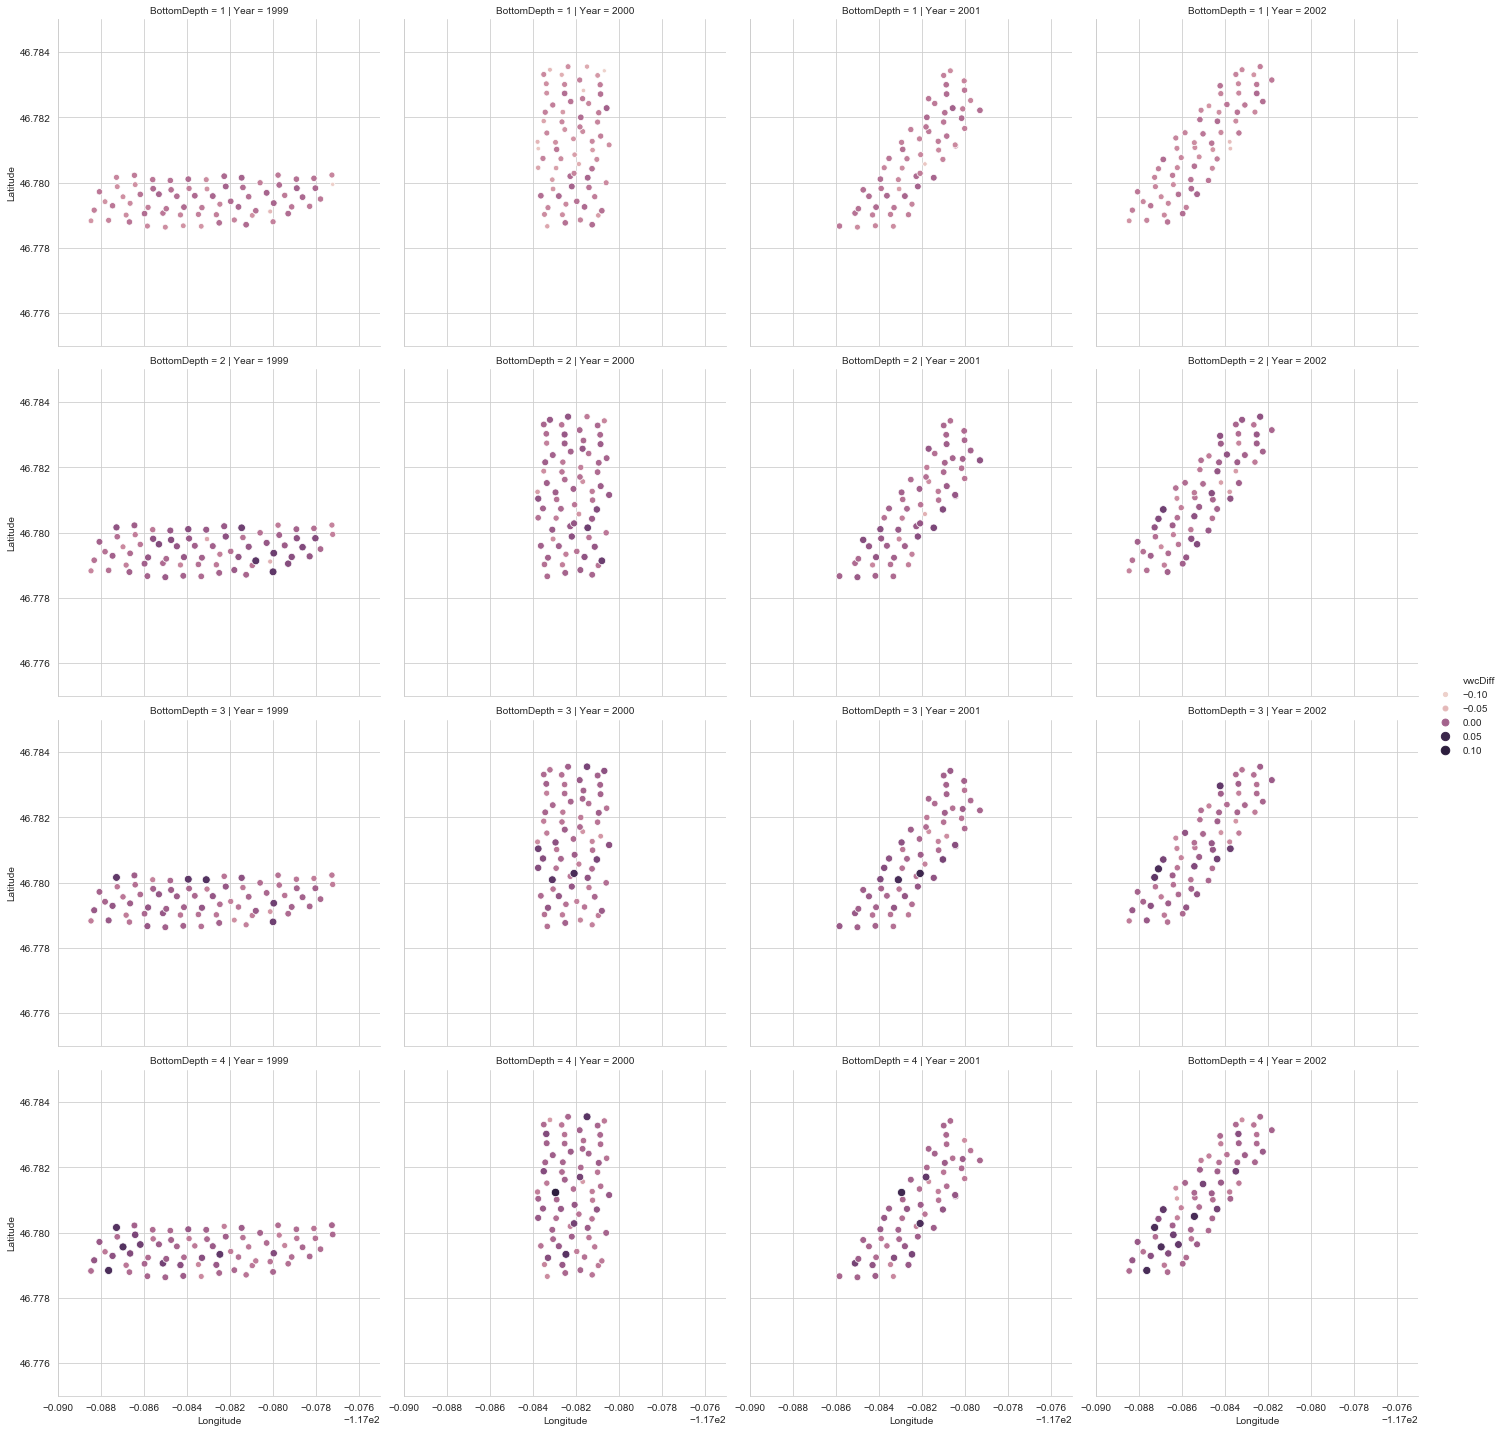

In [16]:
sliceEarlyYearsFall = gdf[(gdf["Season"] == "Fall") & (gdf["Year"] < 2003)]
g = sns.relplot(
    data = sliceEarlyYearsFall,
    x="Longitude",
    y="Latitude",
    col="Year",
    row="BottomDepth",
    kind="scatter",
    size="vwcDiff", 
    hue="vwcDiff")
g.set(ylim=(46.775, 46.785))
g.set(xlim=(-117.090, -117.075))

In [17]:
qs = sliceEarlyYearsFall["vwcDiff"].quantile([0.25, 0.50, 0.75])

q1 = qs[0.25]
q3 = qs[0.75]
iqr = q3 - q1

lowOutlier = q1 - (iqr * 3)
highOutlier = q3 + (iqr * 3)

(sliceEarlyYearsFall[(sliceEarlyYearsFall["vwcDiff"] < lowOutlier) | (sliceEarlyYearsFall["vwcDiff"] > highOutlier)]
    .merge(revisedVwc, how = "left", on = ["Year", "Season", "ID2", "BottomDepth"])
    .drop(columns = dropColsForPrettyPrint)
    .sort_values(by = ["ID2", "Year", "Season", "BottomDepth"]))

ID2  Year Season  BottomDepth  VolumetricWaterContent_legacy  \
0  233  2000   Fall            4                       0.300467   

   VolumetricWaterContent_revised  vwcDiff  TopDepth  BulkDensity  \
0                        0.243378  0.05709         3     1.239296   

   GravimetricWaterContent   Nitrate  Ammonia Notes  
0                 0.196384  4.191214      0.0   NaN

### Years: 2003-2003, Season: Fall

In [18]:
sliceLateYearsFall = gdf[(gdf["Season"] == "Fall") & (gdf["Year"] > 2002)]
g = sns.relplot(
    data = sliceLateYearsFall,
    x="Longitude",
    y="Latitude",
    col="Year",
    row="BottomDepth",
    kind="scatter",
    size="vwcDiff", 
    hue="vwcDiff")
g.set(ylim=(46.775, 46.785))
g.set(xlim=(-117.090, -117.075))

In [19]:
qs = sliceLateYearsFall["vwcDiff"].quantile([0.25, 0.50, 0.75])

q1 = qs[0.25]
q3 = qs[0.75]
iqr = q3 - q1

lowOutlier = q1 - (iqr * 3)
highOutlier = q3 + (iqr * 3)

(sliceLateYearsFall[(sliceLateYearsFall["vwcDiff"] < lowOutlier) | (sliceLateYearsFall["vwcDiff"] > highOutlier)]
    .merge(revisedVwc, how = "left", on = ["Year", "Season", "ID2", "BottomDepth"])
    .drop(columns = dropColsForPrettyPrint)
    .sort_values(by = ["ID2", "Year", "Season", "BottomDepth"]))

ID2  Year Season  BottomDepth  VolumetricWaterContent_legacy  \
1   17  2003   Fall            3                       0.419615   
0  377  2004   Fall            1                       0.233041   

   VolumetricWaterContent_revised   vwcDiff  TopDepth  BulkDensity  \
1                        0.349022  0.070592         2     1.172795   
0                        0.315294 -0.082253         0     1.434130   

   GravimetricWaterContent    Nitrate   Ammonia Notes  
1                 0.297599   2.186628  2.274968   NaN  
0                 0.219850  11.200774  2.183948   NaN